In [11]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from math import log2

# Path to your QA folder
qa_dir = "../../OmniMedVQA/QA_information"
images_dir = "../../OmniMedVQA/Images"

open_access_dir = os.path.join(qa_dir, "Open-access")
restricted_access_dir = os.path.join(qa_dir, "Restricted-access")

In [10]:
# Collect answers grouped by dataset
dataset_answers = defaultdict(list)

def load_json(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return json.load(f)

# Iterate through Open- and Restricted-access JSONs
for folder in [open_access_dir, restricted_access_dir]:
    for filename in os.listdir(folder):
        if filename.endswith(".json"):
            file_path = os.path.join(folder, filename)
            try:
                data = load_json(file_path)
                for item in data:
                    dataset_name = item.get("dataset", "Unknown")
                    answer = item.get("gt_answer", None)
                    if answer:
                        dataset_answers[dataset_name].append(answer)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

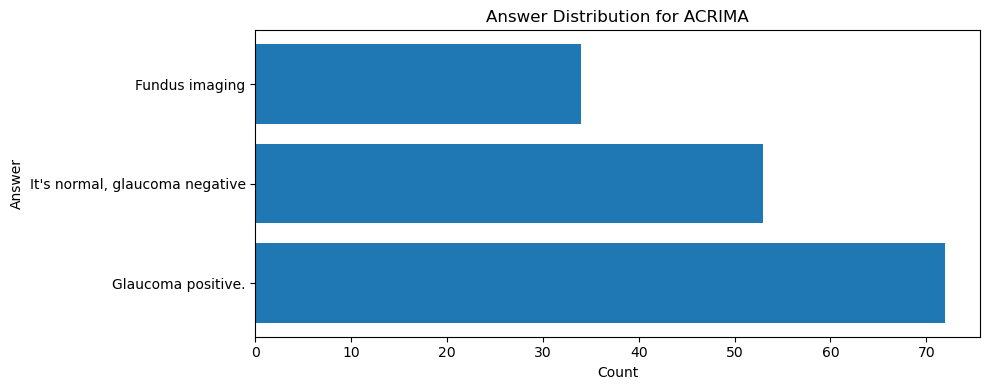

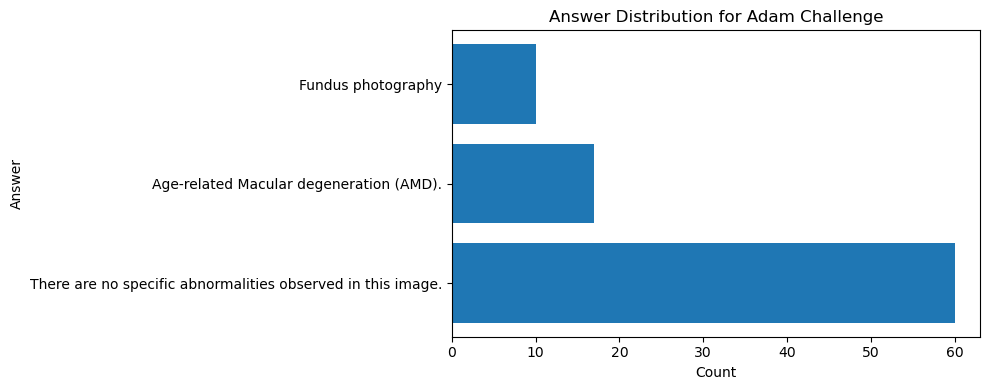

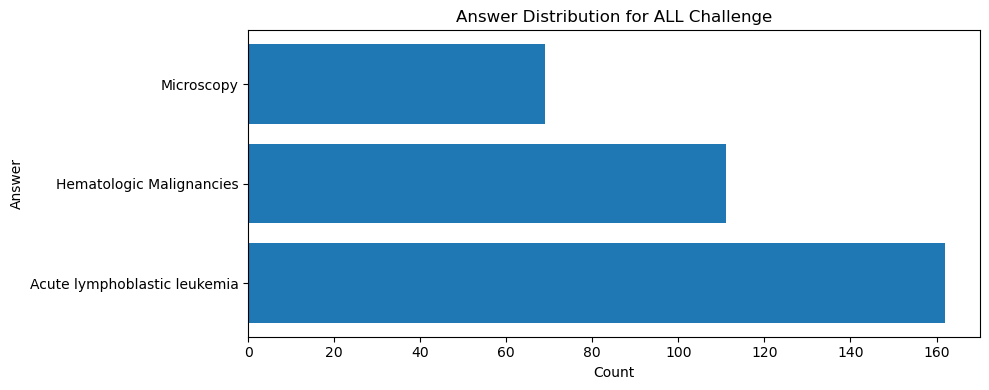

In [4]:
max_plots = 3  # how many datasets to plot
for i, (dataset_name, answers) in enumerate(dataset_answers.items()):
    if i >= max_plots:  # stop after X plots
        break
    
    counts = Counter(answers)
    labels, values = zip(*counts.most_common())
    
    plt.figure(figsize=(10, max(4, len(labels) * 0.4)))
    plt.barh(labels, values)
    plt.xlabel("Count")
    plt.ylabel("Answer")
    plt.title(f"Answer Distribution for {dataset_name}")
    plt.tight_layout()
    plt.show()


## Answer Distribution

The charts below show the distribution of answer choices for a few example datasets.  
For instance, the **Adam Challenge** (and several others with similar patterns) exhibit a strong skew toward one particular answer choice.  
This indicates a noticeable **answer bias**, where one option dominates the dataset.  
As a result, it becomes more difficult to draw balanced conclusions since there are fewer examples for the less frequent answers.


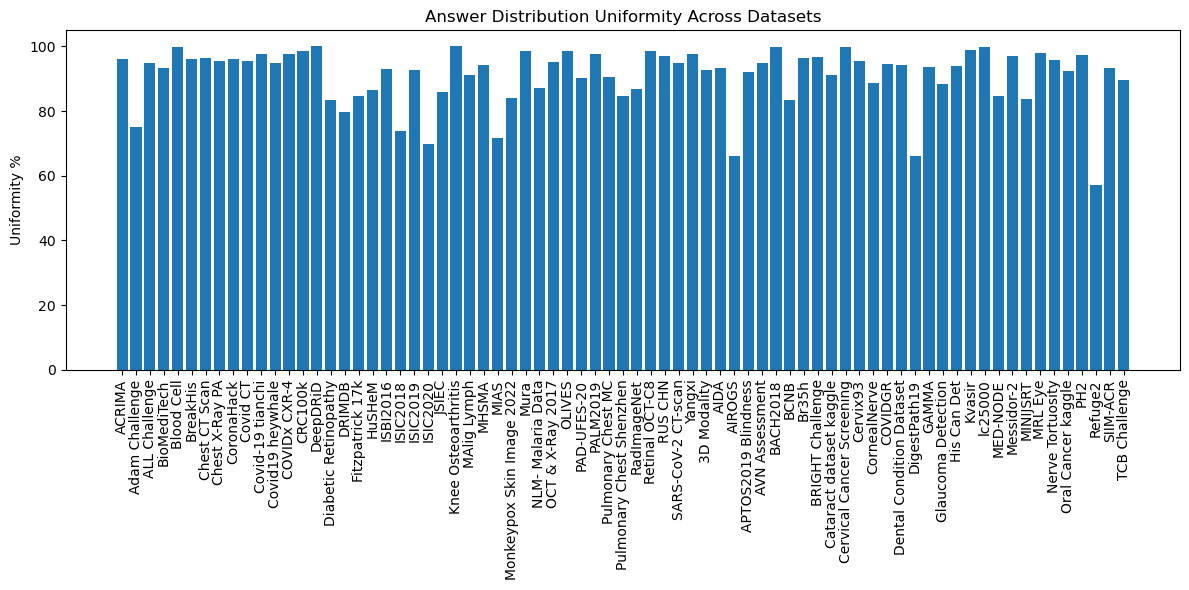

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from math import log2

def entropy(probs):
    return -sum(p * log2(p) for p in probs if p > 0)

uniformity_scores = {}

for dataset_name, answers in dataset_answers.items():
    counts = Counter(answers)
    total = sum(counts.values())
    probs = [c/total for c in counts.values()]
    
    if len(counts) == 1:
        # If only one unique answer, define uniformity as 100%
        uniformity = 100.0
    else:
        # entropy of actual distribution
        H_actual = entropy(probs)
        # entropy of uniform distribution (max possible)
        H_uniform = log2(len(counts))
        uniformity = (H_actual / H_uniform) * 100
    
    uniformity_scores[dataset_name] = uniformity

# Plot
plt.figure(figsize=(12,6))
plt.bar(uniformity_scores.keys(), uniformity_scores.values())
plt.xticks(rotation=90)
plt.ylabel("Uniformity %")
plt.title("Answer Distribution Uniformity Across Datasets")
plt.tight_layout()
plt.show()



## Answer Distribution Uniformity

This plot highlights which datasets have the lowest answer uniformity, meaning their results are heavily skewed toward one option.  
For example, **Refuge2** and **AIROGS** show some of the strongest imbalances, with one answer choice appearing far more often than the others.  
Such skew makes it harder for models to learn balanced decision-making across all possible answers.


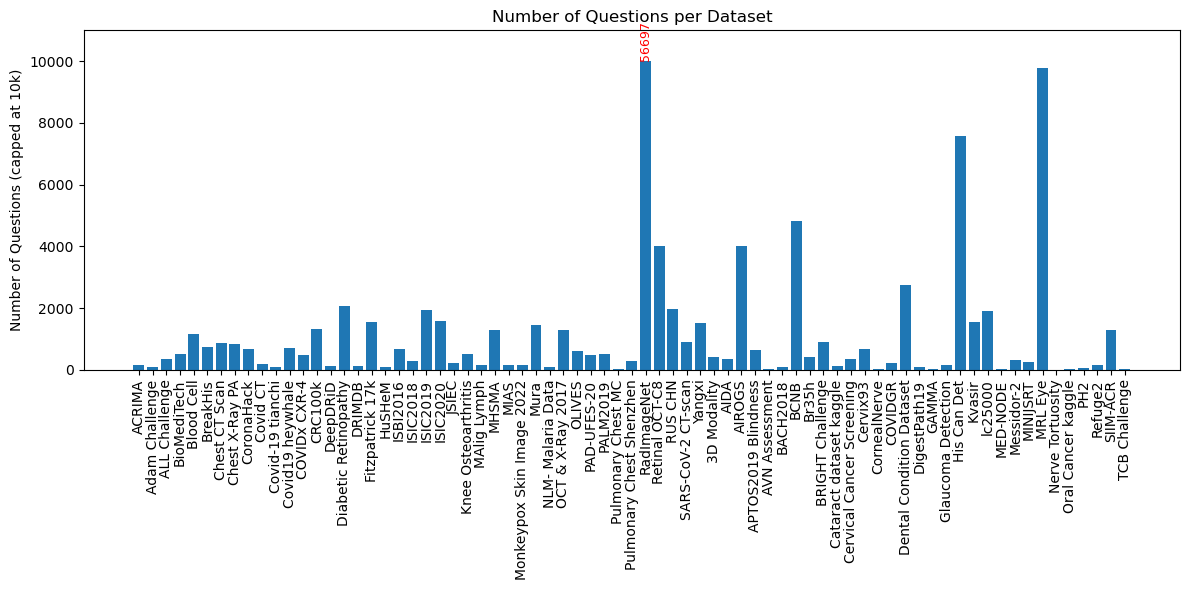

In [6]:
# Count how many questions per dataset
dataset_sizes = {dataset_name: len(answers) for dataset_name, answers in dataset_answers.items()}

cap_value = 10000

plt.figure(figsize=(12,6))
bars = plt.bar(dataset_sizes.keys(), 
               [min(v, cap_value) for v in dataset_sizes.values()])

plt.xticks(rotation=90)
plt.ylabel("Number of Questions (capped at 10k)")
plt.title("Number of Questions per Dataset")

# Annotate bars that exceed the cap
for bar, (dataset_name, size) in zip(bars, dataset_sizes.items()):
    if size > cap_value:
        plt.text(bar.get_x() + bar.get_width()/2, 
                 cap_value, 
                 f"{size}", 
                 ha='center', va='bottom', fontsize=9, rotation=90, color="red")

plt.ylim(0, cap_value*1.1)  # give some space above cap
plt.tight_layout()
plt.show()


## Number of Questions per Dataset

This plot shows how the number of questions varies across datasets.  
For instance, **RadImageNet** contains nearly 57k questions, while the next largest dataset has only around 10k.  
This imbalance means that some datasets are far more represented than others, which is important to keep in mind when drawing conclusions from the data.


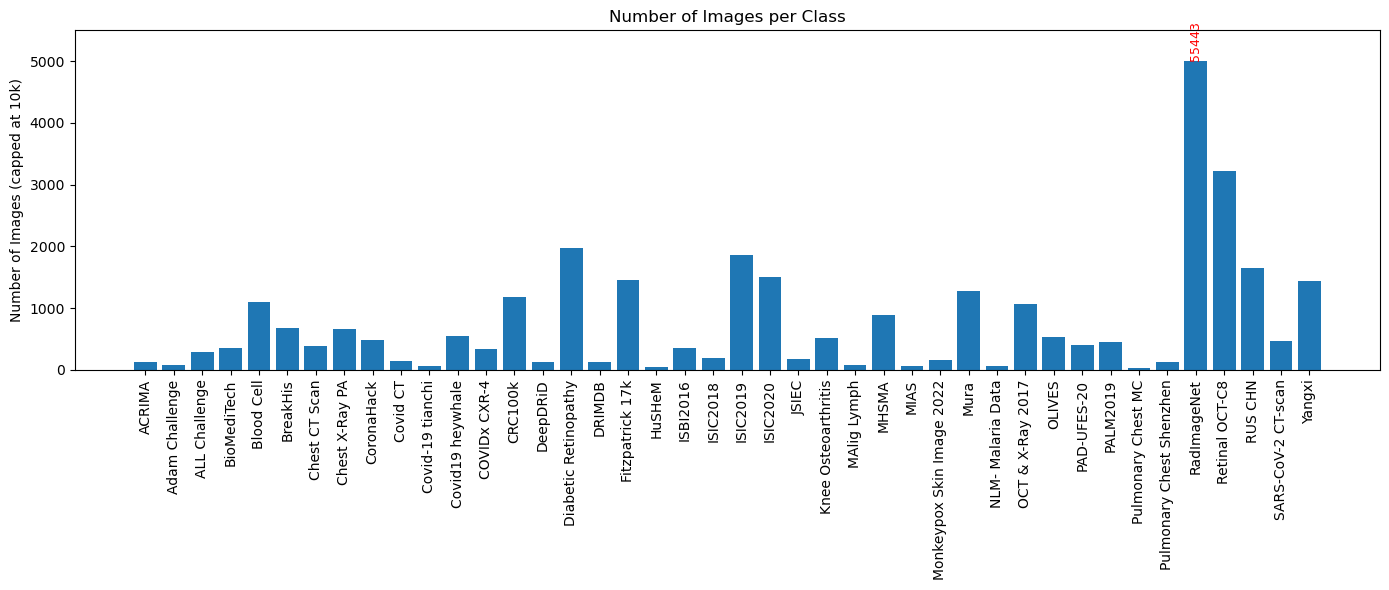

In [9]:
cap_value = 5000

# Allowed image extensions
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif')

# Dictionary to store counts
image_counts = {}

# Walk through each subdirectory in Images
for subdir in os.listdir(images_dir):
    subdir_path = os.path.join(images_dir, subdir)
    if os.path.isdir(subdir_path):
        count = 0
        # Recursively walk through the subdirectory
        for root, _, files in os.walk(subdir_path):
            for file in files:
                if file.lower().endswith(image_extensions):
                    count += 1
        image_counts[subdir] = count

# Plot
plt.figure(figsize=(14,6))
bars = plt.bar(image_counts.keys(), [min(v, cap_value) for v in image_counts.values()])
plt.xticks(rotation=90)
plt.ylabel("Number of Images (capped at 10k)")
plt.title("Number of Images per Class")

# Annotate bars that exceed the cap
for bar, (subdir, count) in zip(bars, image_counts.items()):
    if count > cap_value:
        plt.text(bar.get_x() + bar.get_width()/2,
                 cap_value,
                 f"{count}",
                 ha='center', va='bottom', fontsize=9, rotation=90, color="red")

plt.ylim(0, cap_value*1.1)  # some space above the cap
plt.tight_layout()
plt.show()


## Number of Images per Dataset

The distribution of images follows a similar pattern to the question counts.  
For example, **RadImageNet** contains nearly 56k images, while the next largest dataset has only about 3k.  
This imbalance again highlights how certain datasets dominate the collection, which can influence model training and evaluation.
